# Align spectra
Measure the shift between the master spectrum and each frame, correct the misalignment by spline interpolating on a new shifted grid. 

In [7]:
#------ manually fix import for now
import sys
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.align import Align


c = 2.99e5
%load_ext autoreload
%autoreload 2

In [167]:
night = '1'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/'.format(night)
read_from_files = False # set to `True` the first time running it

if read_from_files:
    files = sorted(glob.glob(data_dir+'*_{:}_ms1d.fits'.format(position))) # select files
    dc = read_giano(files)
    dc.save(data_dir+'datacube_input.npy')
else:
    dc = Datacube().load(data_dir+'datacube_input.npy')


Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/datacube_input.npy


### Wavelength solution over time
We look at the wavelength solution of all frames for a single order and compare it to the median.

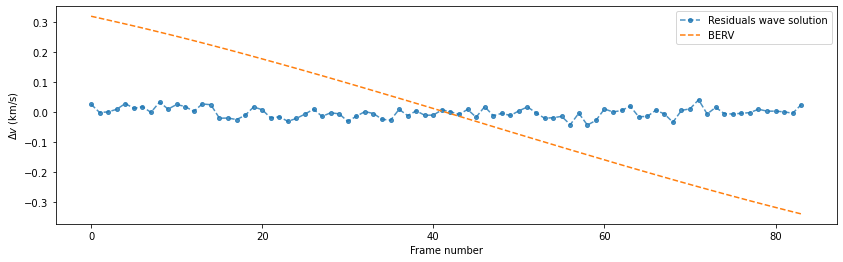

In [493]:
dco = dc.order(44)
wavesol = np.median(dco.wlt, axis=0)
cenwave = np.median(wavesol)

fig, ax = plt.subplots(1,figsize=(14,4))
# for i in np.arange(0,dco.nObs,22):
#     ax.bar(i, np.mean(wavesol - dco.wlt[i,]), alpha=0.8)#, label='Frame {:}'.format(i))
    
ax.plot(np.arange(0,dco.nObs), c*np.mean(wavesol - dco.wlt, axis=1)/(cenwave),
        '--o', alpha=0.8, ms=4., label='Residuals wave solution')  
ax.plot(dco.BERV - np.median(dco.BERV), '--', label='BERV')
# ax.plot(wavesol)
ax.legend()
ax.set(ylabel='$\Delta v$ (km/s)', xlabel='Frame number')
plt.show()

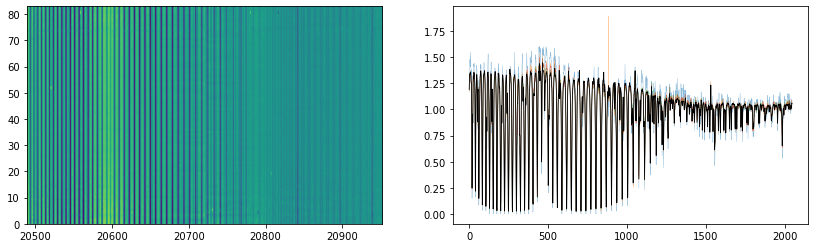

In [494]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
dco.remove_continuum().imshow(ax=ax[0])

master = Template(wlt=xpixels, flux=np.median(dco.flux, axis=0)).high_pass_gaussian(150)

for i in np.arange(0,dco.nObs,22):
    ax[1].plot(dco.flux[i,], alpha=0.5, lw=0.4)
    
ax[1].plot(master.flux, lw=0.8, c='k')
plt.show()

### Find tellurics
* First, we find the approximate location of telluric lines in the master spectrum.
* For each frame, we locate the (sub)pixel position of a set of *reference* telluric lines

[  18   61  106  207  432  479  530  836  902  970 1040 1112 1161 1232
 1493 1580 1627 1985]


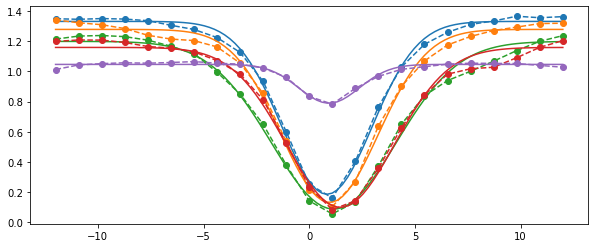

In [495]:
from scipy.signal import find_peaks

def gauss(x, *p):
    A, mu, sigma, c = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + c

def fit_lines(wlt, flux, peaks, ax=None):
    from scipy.optimize import curve_fit
    dx = 12
    centroids = []
    # peaks must be indices (integers), else round them to nearest int
    if peaks.dtype != int:
        peaks = np.rint(peaks).astype(int)
        
    centroids = np.zeros(len(peaks))
        
    for i,xcen in enumerate(peaks):
        if xcen is np.nan:
            centroids[i] = np.nan
        else:
            x = wlt[xcen-dx:xcen+dx-1]
            y = flux[xcen-dx:xcen+dx-1]
            
            p0 = [-0.5, wlt[xcen], 1., np.median(flux)]
            xfit = np.linspace(x.min(), x.max(), 100)
            coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
    #         print(coeff[1], var_matrix[1][1])
            if var_matrix[1][1]<0.01:
                centroids[i] = coeff[1]

                if not ax is None:
                    fit = gauss(xfit, *coeff)
                    line_data, = ax.plot(np.linspace(-dx,dx, y.size), y, '--o', label=np.round(coeff[1],2))
                    ax.plot(np.linspace(-dx,dx,fit.size), fit, ls='-', c=line_data.get_color())

            else:
                centroids[i] = np.nan
            
    return centroids

def get_peaks(spectrum, sat=0.05, edge=12, threshold=0.05):
    '''given a normalised *emission* spectrum (Template instance), find peaks that satisfy:
    - threshold 
    - sat = mask out saturated peaks (below sat)
    - edge = mask out peaks near the edges'''
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(-spectrum.flux, threshold=0.05, distance=40)
    edges = (peaks < edge) + (peaks > spectrum.wlt.size+edge)
    peaks = peaks[~edges]
    
    sat = spectrum.flux[peaks] < sat
    
    peaks = peaks[~sat]
    return peaks

def spline_super_sampling(wlt,flux,scale_pix,centroid, ax=None):
    from scipy.interpolate import splrep, splev
    '''scale in A (use solution pixel-wave)'''
    dx = 8 # pixels
    xcen_ind = np.rint(centroid).astype(int)        
    x = wlt[xcen_ind-dx:xcen_ind+dx-1]
    y = flux[xcen_ind-dx:xcen_ind+dx-1]
    
    # spline interpolate
    cs = splrep(x, y)
    ss_x = np.arange(x.min(), x.max(), scale_pix)
    ss_line = splev(ss_x, cs)
    
    # get refined centroid
    min_frac_pix = int(np.argwhere(ss_line==ss_line.min())[0]) # fractional pixel with minimum flux
    centroid_pix = xcen_ind-dx + min_frac_pix*scale_pix

    
    if ax != None:
        ax.plot(x,y, '*', label='Data')
        ax.plot(ss_x, ss_line,'--o', ms=1., alpha=0.4, label='Super-sampled line')
    
    return centroid_pix
    
fig, ax = plt.subplots(1,figsize=(10,4))

peaks = get_peaks(master)
print(peaks)

cent = fit_lines(xpixels, master.flux, peaks, ax=ax)

[ 432  530  836  902 1493]


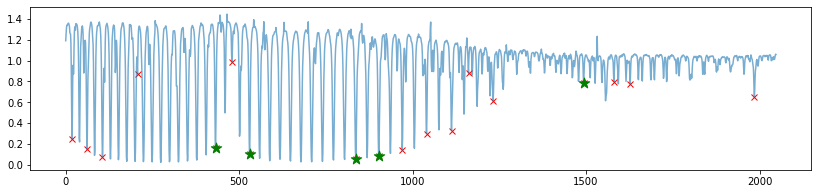

In [503]:
%matplotlib inline
# peaks, _ = find_peaks(-master.flux, threshold=0.05, distance=50)
fig, ax = plt.subplots(1,figsize=(14,3))

ax.plot(peaks, master.flux[peaks], 'xr')

nans = np.isnan(cent)
centroids = np.rint(cent[~nans]).astype(int)
print(centroids)
ax.scatter(centroids, master.flux[centroids],marker='*',s=120, c='g',zorder=100)

ax.plot(master.flux, alpha=0.6)
plt.show()

In [497]:
cent

array([          nan,           nan,           nan,           nan,
        431.77289558,           nan,  529.88602448,  836.06603881,
        902.35392866,           nan,           nan,           nan,
                 nan,           nan, 1492.86156281,           nan,
                 nan,           nan])

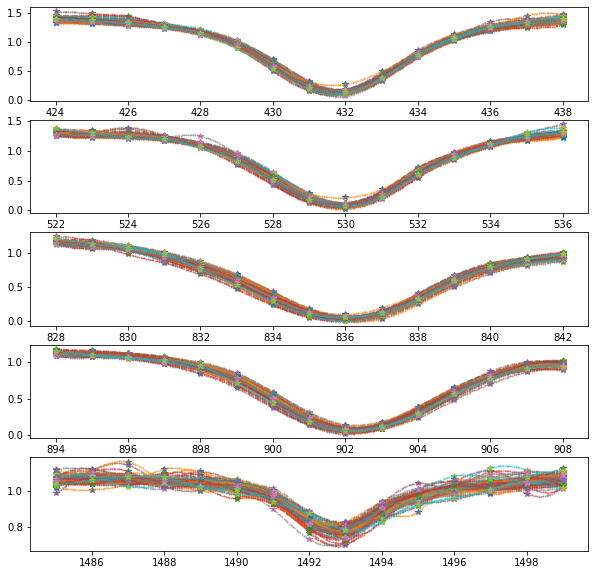

In [498]:


scale_pix = 1/20.
n_lines = cent[~nans].size
fig, ax = plt.subplots(n_lines, figsize=(10,n_lines*2))
# spline_super_sampling(master.wlt, master.flux,scale_pix, cent[0], ax=ax)

master_j = np.zeros(n_lines)
cent_ij = np.zeros((dco.nObs, n_lines))

for j,line in enumerate(cent[~nans]):
    master_j[j] = spline_super_sampling(master.wlt, master.flux, scale_pix, line, ax=ax[j])
    for i in np.arange(0,dco.nObs):        
        cent_ij[i,j] = spline_super_sampling(xpixels,dco.flux[i],scale_pix, line, ax=ax[j])
    
plt.show()

[  18   61  106  207  432  479  530  836  902  970 1040 1112 1161 1232
 1493 1580 1627 1985]


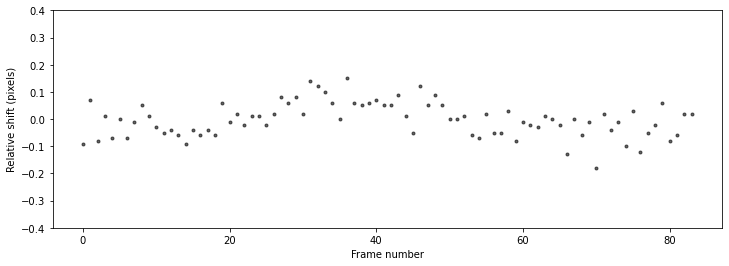

In [511]:
peaks = get_peaks(master)
print(peaks)

# get lines' centroids in the master spectrum
cent = fit_lines(xpixels, master.flux, peaks)

# spline interpolate to get an accurate position of the lines in all frames (and master)
scale_pix = 1/20.
n_lines = cent[~nans].size

# master_j = np.zeros(n_lines)
# cent_ij = np.zeros((dco.nObs, n_lines))
shift_ij = np.zeros((dco.nObs, n_lines))

for j,line in enumerate(cent[~nans]):
    master_cent = spline_super_sampling(master.wlt, master.flux, scale_pix, line)
    for i in np.arange(0,dco.nObs):        
        cent_i = spline_super_sampling(xpixels,dco.flux[i], scale_pix, line)
        shift_ij[i,j] = cent_i - master_cent
        
fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(np.mean(shift_ij, axis=1), '.', c='k', alpha=0.6)
ax.set(xlabel='Frame number', ylabel='Relative shift (pixels)', ylim=(-0.4, 0.4))
plt.show()        

## Call an `Align` instance to run the complete process

In [70]:
dco = dc.order(48).remove_continuum()
dco.wlt = np.arange(0, dco.nPix)
al = Align(dco)

Working with 5 lines


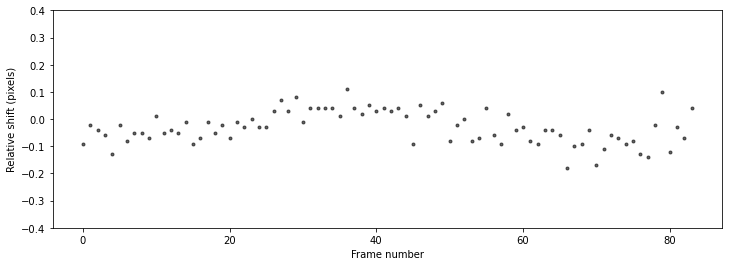

In [71]:
fig, ax = plt.subplots(1, figsize=(12,4))
al.get_peaks().fit_lines().compute_shifts(ax=ax)
ax.set(ylim=(-0.4, 0.4))

plt.show()

In [72]:
al.apply_shifts()

Working with 5 lines


<AxesSubplot:>

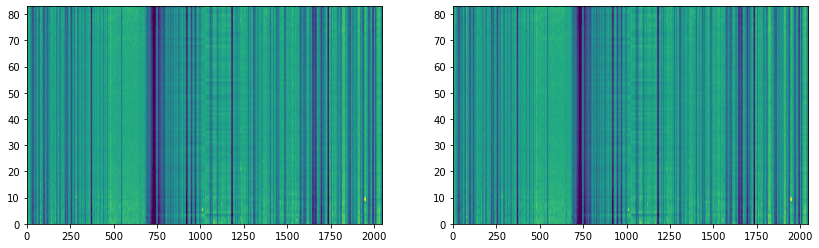

In [73]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
dco.imshow(ax=ax[0])
al.dco.imshow(ax=ax[1])

In [208]:
order = 49
dco = dc.order(order).remove_continuum()
# dco.wlt = np.arange(0, dco.nPix)
al = Align(dco)
al.apply_shifts(ax)

# call a second time to see the difference
al2 = Align(al.dco).apply_shifts(ax)
out_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/plots/'


Working with 4 lines
Working with 4 lines


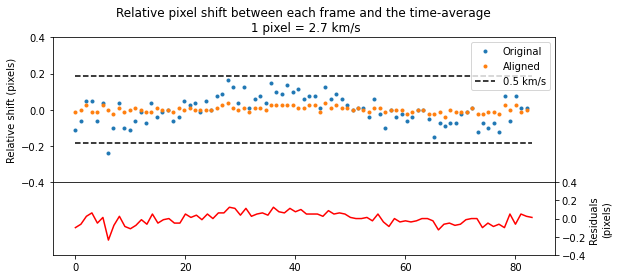

In [209]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(9,4))
gs = gridspec.GridSpec(6,1)
gs.update(wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(gs[:4,:])
ax2 = fig.add_subplot(gs[-2:,:], sharey=ax1)

ax1.set_xticks([])
ax2.yaxis.tick_right()

s1 = np.mean(al.shift_ij, axis=1)
s2 = np.mean(al2.shift_ij, axis=1)
res = s1-s2
ax1.plot(s1, '.', label='Original')
ax1.plot(s2, '.', label='Aligned')

ax2.plot(res, 'r')
ax1.set(ylim=(-0.4, 0.4), xlabel='Frame number', ylabel='Relative shift (pixels)')
ax2.set(ylabel='Residuals \n(pixels)')
ax2.yaxis.set_label_position("right")


rv_scale = 0.5
ax1.hlines([-rv_scale/2.7, rv_scale/2.7], xmin=0, xmax=dco.nObs, ls='--', color='k', label='{:} km/s'.format(rv_scale))
ax1.legend()
ax1.set_title('Relative pixel shift between each frame and the time-average\n 1 pixel = 2.7 km/s')

plt.show()
# fig.savefig('{:}giano_rdrift_night{:}_pos{:}_order{:}_aligned.png'.format(out_dir, night, position, order), 
#             dpi=200, bbox_inches='tight', facecolor='white')

Good job!!! Same results as the hand-picked telluric lines
We get results that are clearly sub-pixel, are they that relevant??

In [ ]:
### TO-DO
--> wavelength solution by comparing with telluric template